# Họ và tên: Lò Anh Đức

**Mã sinh viên: 19021243**

# Mô tả bài toán
Dự đoán giá sản phẩm dựa trên 1 vài dữ liệu cho trước.

**Đầu vào:** Tên sản phẫm, tình trạng, phân loại, nhãn hàng, phí ship, ghi chú

**Đầu ra:** Giá dự đoán (USD)

Điểm số được tính theo công thức:
\begin{align*}
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
\end{align*}
* RMSLE: Root Mean Squared Logarithmic Error
* n: số quan sát
* $p_i$: giá dự đoán 
* $a_i$: giá trị thực 
* log(x): logarit tự nhiên

In [ ]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

Đây là dạng bài hồi quy, ta cần đi tìm 1 biểu diễn $y = f(x)$. 

# Phân tích và xử lý dữ liệu

Thêm các thư viện cần thiết, trong notebook này, ta sử dụng numpy cho đại số tuyến tính, pandas, sklearn để load dữ liệu và keras để xây dựng model học máy.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
import time

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

import math
from subprocess import check_output
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

Load dữ liệu 

In [ ]:
train = pd.read_table("../input/mercari/train.tsv")
test = pd.read_table("../input/mercari/test_stg2.tsv")

Kiểm tra dữ liệu

In [ ]:
train.head()

In [ ]:
test.head()

Kiểm tra số lượng dữ liệu trong tập train và test. Tập train có 8 trường: id, name, item_condition_id, category_name, brand_name, price, shipping, item_description. Tập test không có trường price (label)

In [ ]:
print(train.shape)
print(test.shape)

**Clean dữ liệu**

Mercari không cho phép các mặt hàng < $3.0. Vì thế ta bỏ các giá trị này khỏi tập train. 

In [ ]:
train = train.drop(train[(train.price < 3.0)].index)
print(train.shape)

Kiểm tra số lượng các trường không có giá trị. Nhận thấy dữ liệu chủ yếu không có nhãn brand. Một vài dữ liệu thiếu dữ liệu phân loại.

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

Kiểm tra dữ liệu loại hàng (category). Có 1287 nhãn riêng biệt. Mỗi nhãn bao gồm 3 nhãn con ngăn cách bằng '/'. Dữ liệu đầu vào cho model dưới dạng số, ta sẽ phải mã hóa cho những nhãn này. Nếu sử dụng những mã hóa đơn giản như onehot dễ làm mất sự liên quan giữa 2 nhãn, ví dụ "Beauty/Makeup/Face" và "Beauty/Makeup/Lips" sẽ được mã hóa khác nhau trong khi ta cần thể hiện 1 mối quan hệ ở đây. Nếu sử dụng các mô hình ngôn ngữ để trích trọn đặc trưng thì sẽ là quá phức tạp về chi phí tính toán. Một giải pháp đơn giản là chia 3 nhãn này thành 3 cột nữa trong bảng dữ liệu.

In [ ]:
category_count = train['category_name'].value_counts()
print(category_count)

In [ ]:
def split_cat(text):
    try: return text.split("/")
    except: return ("None", "None", "None")

Chia loại hàng và kiểm tra dữ liệu sau khi chia

In [ ]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

In [ ]:
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))
test.head()

Sau khi chia loại hàng thành 3 cột. Ta xử lý trường hợp thiếu dữ liệu.

In [ ]:
def handle_missing(dataset):
    dataset.category_name.fillna(value="None", inplace=True)
    dataset.brand_name.fillna(value="None", inplace=True)
    dataset.item_description.fillna(value="None", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print("Handed missing values!")

Kiểm tra

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

**Phân tích dữ liệu**

Bằng kiến thực thực tế, ảnh hưởng nhất tới giá của 1 mặt hàng phụ thuộc nó là mặt hàng gì. Những mặt hàng cùng loại có khả năng có 1 phân bố về giá nào đó. Ta cần phân tích về dữ liệu category sau khi đã chia nhỏ.

Nhận thấy trong tập dữ liệu, nhóm hàng dành cho phụ nữ, làm đẹp, đồ trẻ em và đồ điện chiếm đa số.

In [ ]:
gencat_count = train['general_cat'].value_counts()
print(gencat_count)

Trong đó thì các mặt hàng về đồ trang điểm, dụng cụ thể dục, quần áo và giày dép có số lượng nhiều.

In [ ]:
subcat1_count = train['subcat_1'].value_counts()
print(subcat1_count)

Cụ thể hơn nữa

In [ ]:
subcat2_count = train['subcat_2'].value_counts()
print(subcat2_count)

Ảnh hưởng lớn thứ 2 tới giá cả chính là nhãn hiệu. Đồ của những nhãn hiệu nổi tiếng thường có giá vượt trội. Ngoài ra giá của các nhãn hiệu nổi tiếng là niêm yết, ổn định, ít nhiễu. Không may, tập dữ liệu huấn luyện chủ yếu là hàng không có nhãn hiệu.

In [ ]:
import seaborn as sns
brand_count = train['brand_name'].value_counts()
sns.barplot(x=brand_count[:10].values, y=brand_count[:10].index)
plt.title('Frequency Distribution of top 10 brand names')
plt.xlabel('Counts', fontsize=12)
plt.show()

Ghi chú về hàng cũng có ảnh hưởng lớn. Tuy nhiên nó lại không cụ thể (cũ mới như trạng thái hàng) mà phụ thuộc vào ý nghĩa, ngữ cảnh ghi chú. Có thể ta sẽ cần sử dụng mô hình ngôn ngữ để trích xuất đặc trưng của dữ liệu này. Tuy nghiên, một cách trực quan, đơn giản ta có thể xem xét quan hệ giữa số lượng từ ngữ ghi chú và giá.

Đầu tiên là thêm 1 cột về số lượng từ trong ghi chú.

In [ ]:
train['description_wc'] = [len(str(i).split()) for i in train['item_description']]

In [ ]:
test['description_wc'] = [len(str(i).split()) for i in test['item_description']]

kiểm tra

In [ ]:
train.head()

Phân bố lượng từ của ghi chú. Dễ thấy các ghi chú hầu hết < 50 từ.

In [ ]:
sns.boxplot(train['description_wc'],orient='v')
plt.title("Box plot of description word count")
plt.xlabel("item_description")
plt.ylabel("No. of words")
plt.show()

Biểu đồ quan hệ giữa giá cả và độ dài của ghi chú.

In [ ]:
plt.scatter(train['description_wc'],train['price'],alpha=0.4)
plt.title("Price Vs Description length")
plt.xlabel("Description length")
plt.ylabel("Price(USD)")
plt.show()

Không rõ ràng nhưng có sự liên hệ giữa lượng từ và giá. Lượng từ các nhiều, giá có xu hướng giảm. Do đó, ta có thể dụng lượng từ ghi chú như là 1 đặc trưng mới, bên cạnh 3 đặc trưng về loại ở phía trên.

Một vài phương pháp đặt điểm cao trên leader board phân tích thêm nhiều đặc trưng khác, như tên. Tách các từ trong tên, join với các trường khác,...etc Tuy nhiên vì độ phức tạp tính toán, trong notebook này, ta sẽ chỉ thêm 4 đặc trưng đã trình bày phía trên.

Phân tích tiếp theo về phân bố giá sản phẩm. Có thể thấy phân bố này lệch trái về các sản phẩm < $100

In [ ]:
sns.distplot(train['price'].values)

Đối với các mô hình học máy và hồi quy nói riêng, phân bố này khó để sử dụng. Ta cần đưa nó về phân bố chuẩn. Có rất nhiều cách, tuy nhiên đơn giản nhất là lấy log của giá.

In [ ]:
sns.distplot(np.log(train['price'].values+1))

Mặc dù chưa hoàn hảo nhưng phân bố này cũng rất gần với phân bố chuẩn, có thể sử dụng tốt.

Cuối cùng, ta xem xét quan hệ của phí ship (có hay không) với giá. Dễ hiểu, những sản phẩm miễn phí ship có giá cao hơn.

In [ ]:
ax = sns.boxplot(x=train['shipping'],y=np.log(train['price'].values+1),palette="Set3",hue=train['shipping'])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["seller pays", "Buyer pays"])
plt.title('Price distribution', fontsize=15)
plt.show()

Tóm lại, sau khi clean và phân tích dữ liệu, ta sẽ sử dụng name, condition, categories, brand, shipping, des, des word count.

Có thể chia thành 2 loại. Dữ liệu đơn: condition, categories, brand, shipping, deswc và dữ liệu dạng chuỗi: name, des.

Với dữ liệu đơn, ta sử dụng 1 mã hóa đơn giản, LabelEncoder() của thư viện sklearn. Hàm này sẽ xếp các nhãn (unique) theo thứ tự alphabet rồi đánh số từ 1 -> n.
Ta mã hóa riêng biệt (vocal riêng) cho từng label (thử nghiệm).

In [ ]:
train.head()

In [ ]:
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)

le.fit(np.hstack([train.general_cat, test.general_cat]))
train.general_cat = le.transform(train.general_cat)
test.general_cat = le.transform(test.general_cat)

le.fit(np.hstack([train.subcat_1, test.subcat_1]))
train.subcat_1 = le.transform(train.subcat_1)
test.subcat_1 = le.transform(test.subcat_1)

le.fit(np.hstack([train.subcat_2, test.subcat_2]))
train.subcat_2 = le.transform(train.subcat_2)
test.subcat_2 = le.transform(test.subcat_2)
del le

train.head()

In [ ]:
test.head()

Với dữ liệu chuỗi, cũng sử dụng 1 mã hóa đơn giản Tokenizer của keras. Hoạt động gần giống như LabelEncoder trình bày phía trên. Có nhiều thảo luận về việc xây dựng vocab chung cho name và des cho hiệu quả hơn. Tuy nhiên trong notebook này, ta xây dựng vocab riêng cho 2 dữ liệu.

In [ ]:
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Như vậy ta đã mã hóa được dữ liệu dạng text thành số bằng cách xây dựng vocab. Các xử lý tiếp theo tùy thuộc vào mô hình được chọn (truyền thống hay deeplearning) được trình bày ở phần sau.

# Mô hình

Việc lựa chọn mô hình được tham khảo tạo bài viết tổng hợp của tác giả đạt 1st prize: https://github.com/pjankiewicz/mercari-solution/blob/master/presentation/build/yandex.pdf

Học máy truyền thống:

**Linear Regression**
Mô hình hồi quy kinh điển, đơn giản, huấn luyện nhanh, phù hợp với dữ liệu có phân bố chuẩn (log price). Kết quả tham khảo: 0.513

**Ridge Regression** hồi quy gần giống với linear Regression, phân tích mối quan hệ giữa các biến độc lập và các biến phụ thuộc sử dụng Regularization, tinh chỉnh mô hình để giảm thiểu các vấn đề Overfitting, tối ưu hay kiểm soát mức độ phức tạp của mô hình để cân đối giữa Biased và Variance, qua đó giảm sai số của mô hình. Kết quả tham khảo: 0.490

Học sâu:

**CNN** Mạng học sâu với sử dụng lớp tích chập có hiệu quả trích chọn đặc trưng rất tốt (chi tiết trong nội dung môn học). Cùng nhiều cải tiến khác, kết quả top 3rd prize: 0.4

**GRU & Conv1D, lightGBM,...** Những mô hình kinh điển trong xử lý ngôn ngữ, kết hợp cùng 1 vài kỹ thuật khác để sử dụng trong bài toán hồi quy này. Trái ngược với hiệu năng tính toán thì kết quả cho ra không thực sự ấn tượng.

**MLP** Với bài toán này, những mô hình đơn giản lại tỏ ra rất hiệu quả và cho kết quả tốt (1st prize) thời gian huấn luyện nhanh.




Qua những tham khảo được tổng hợp bên trên, em đã chọn mô hình MLP cho bài toán này.

MLP là một mô hình kinh điển, nhập môn cho tiếp cận học sâu. MLP tổng quát là mạng có n≥2 tầng trong đó gồm một tầng đầu ra (tầng thứ n) và (n-1) tầng ẩn.
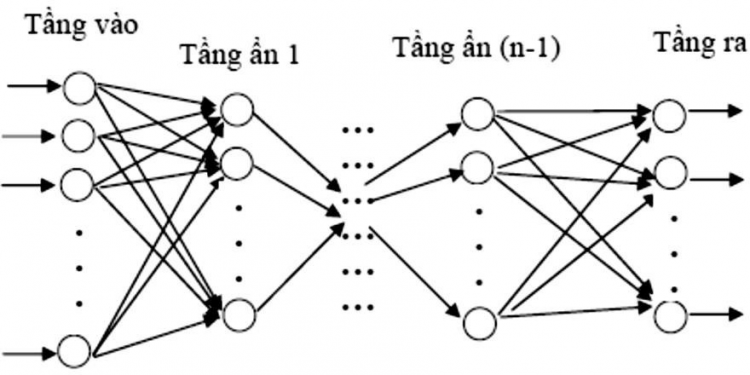

Đầu vào là các vector (x1, x2, …, xp) trong không gian p chiều, đầu ra là các vector (y1, y2, …, yq) trong không gian q chiều.

Mỗi neural thuộc tầng sau liên kết với tất cả các nơron thuộc tầng liền trước nó.

Đầu ra của neural tầng trước là đầu vào của nơron thuộc tầng liền sau nó.

Ngoài kết quả tốt từ thực nghiệm, có 1 đảm bảo lý thuyết là lý do ta chọn mô hình này: "Mọi hàm bất kỳ đều có thể xấp xỉ bởi một mạng MLP 3 tầng sử dụng hàm truyền sigmoid cho các neural tầng ẩn và hàm truyền tuyến tính cho các neural tầng ra."

Các mô hình deep learning đòi hỏi input dưới dạng vector (ma trận). Vì thế nên ta cần xử lý tiếp dữ liệu đã được mã hóa phía trên để chuyển chúng thành các vector embedding. Ta sẽ sử dụng lớp cài đặt embedding có sẵn của keras.

Trước hết cần khảo sát độ dài của 2 dữ liệu chuỗi

In [ ]:
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

In [ ]:
train.seq_name.apply(lambda x: len(x)).hist()

In [ ]:
train.seq_item_description.apply(lambda x: len(x)).hist()

Nhìn 2 biểu đồ histogram phía trên, có thể chọn được không gian embedding cho name là 10, và des là 75 (hầu hết dữ liệu có độ dài ngắn hơn khoảng này nên không gian embedding là tốt mà không quá lớn).

Với các dữ liệu còn lại, ta sử dụng giá trị max làm không gian embedding.

In [ ]:
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_GENCAT = np.max([train.general_cat.max(), test.general_cat.max()])+1
MAX_CAT1 = np.max([train.subcat_1.max(), test.subcat_1.max()])+1
MAX_CAT2 = np.max([train.subcat_2.max(), test.subcat_2.max()])+1
MAX_DESWC = np.max([train.description_wc.max(), test.description_wc.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

Lấy log của price và scale lại trong phân bố chuẩn tắc để làm target huấn luyện.

In [ ]:
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))
pd.DataFrame(train.target).hist()
train.head()

Để việc đánh giá mô hình được thuận tiện, tránh phải submit quá nhiều lần, ta chia tập train thành 8-2 để train và test

In [ ]:
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

Tạo dataset bằng keras với padding

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
        ,'general_cat': np.array(dataset.general_cat)
        ,'subcat_1': np.array(dataset.subcat_1)
        ,'subcat_2': np.array(dataset.subcat_2)
        ,'description_wc': np.array(dataset.description_wc)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

Định nghĩa model. Đầu tiên là các lớp embedding, nhận input dạng số / chuỗi sau đó chuyển thành các vector embedding. 
Riêng với dữ liệu name và des ta sử dụng kiến trúc GRU để trích suất đặc trưng (Phần dưới sẽ trình bày về GRU). Các vector embedding sau đó tiến hành flatten và ghép với output của 2 lớp GRU thành ma trận đặc trưng và được cho qua MLP.

Mô hình MLP được thiết kế với 5 lớp 256x128x64x32x1. Output là 1 số thể hiện giá dự đoán. Qua mỗi layer sử dụng dropout để tránh overfiting. Hàm kích hoạt sử dụng là ReLU (1st prize athor đề xuất).
Có nhiều thảo luận cho rằng nên sử dụng layer BatchNorm để ổn định tham số nhưng qua thực nghiệm em thu được kết quả tệ hơn. Nên em không sử dụng BatchNorm. Hàm lỗi MSE và tối ưu Adam.


Về GRU, để xử lý dữ liệu dạng chuỗi, ta không thể sử dụng những kiến trúc như NN vì các input coi là rời rạc trong khi thứ tự từ trong câu rất quan trọng. Mô hình xử lý dữ liệu chuỗi hay ngôn ngữ nói riêng kinh điển nhất là RNN. Mỗi cell state sẽ nhận input là từ tiếp theo cộng với hidden state của cell phía trước, qua đó giữ được ngữ cảnh toàn câu văn. Tuy nhiên, với những câu dài thì xảy ra hiện tượng vanishing gradient. Để giải quyết vấn đề này, mô hình GRU và LSTM được đưa ra với việc thêm các cổng nhớ, quên,... GRU là mô hình với ít cổng hơn mặc dù hiệu quả là ngang nhau nên em sử dụng GRU để trích chọn đặc trưng cho name và des.

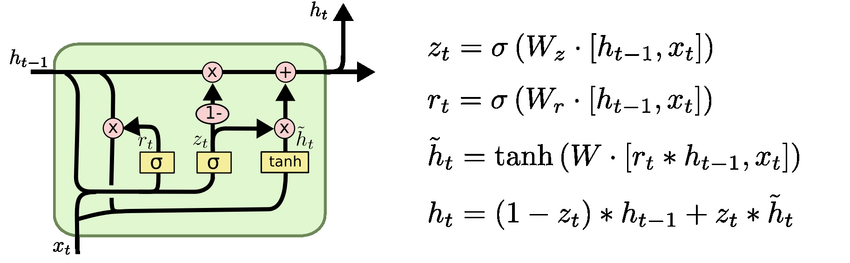!

In [ ]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    drop_rate = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    general_cat = Input(shape=[1], name="general_cat")
    subcat_1 = Input(shape=[1], name="subcat_1")
    subcat_2 = Input(shape=[1], name="subcat_2")
    description_wc = Input(shape=[1], name="description_wc")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 60)(name)
    emb_item_desc = Embedding(MAX_TEXT, 80)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_general_cat = Embedding(MAX_GENCAT, 10)(general_cat)
    emb_subcat_1 = Embedding(MAX_CAT1, 10)(subcat_1)
    emb_subcat_2 = Embedding(MAX_CAT2, 10)(subcat_2)
    emb_description_wc = Embedding(MAX_DESWC, 5)(description_wc)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer2 = GRU(16) (emb_name)
    rnn_layer1 = GRU(32) (emb_item_desc)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_general_cat)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , Flatten() (emb_category_name)
        , Flatten() (emb_description_wc)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(drop_rate) (Dense(256, activation="ReLU") (main_l))
    main_l = Dropout(drop_rate) (Dense(128, activation="ReLU") (main_l))
    main_l = Dropout(drop_rate) (Dense(64, activation="ReLU") (main_l))
    main_l = Dropout(drop_rate) (Dense(32, activation="ReLU") (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, general_cat, subcat_1, subcat_2, 
                   description_wc, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

In [ ]:
BATCH_SIZE = 10000
epochs = 5

model = get_model()
history = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Kết quả huấn luyện

In [ ]:
from matplotlib import pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Kết quả trên tập test

In [ ]:
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: " + str(v_rmsle))

Chạy file test stg2 để submit lên Kaggle

In [ ]:
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

In [ ]:
submission.to_csv("./submission.csv", index=False)

Kiểm tra file test

In [ ]:
tmp = pd.read_table("./submission.csv")

In [ ]:
tmp.describe()

Kết quả:
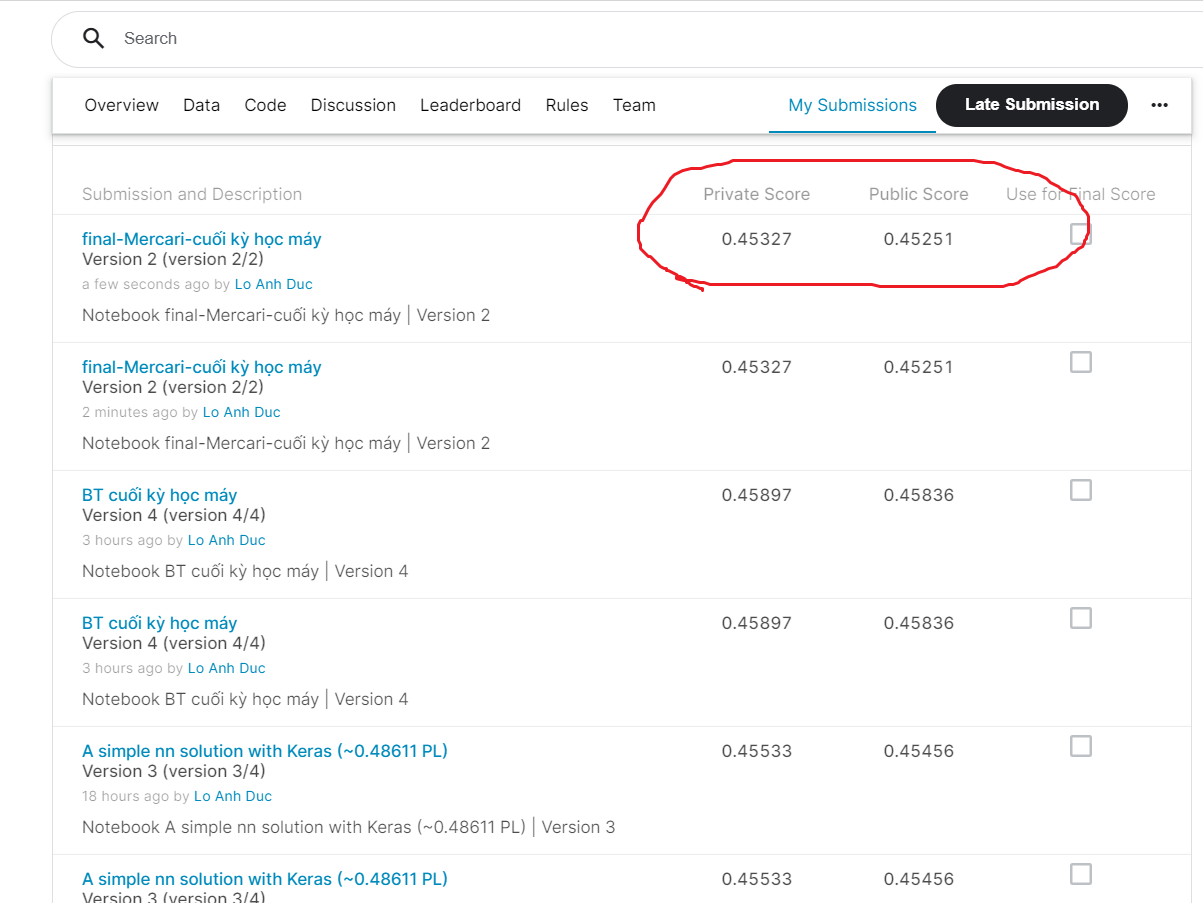